# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Wing Hang CHAN
#### Student ID: 3939713

Date: 16-Sep-2022

Version: 1.0

Environment: Python 3 and Jupyter notebook

## Introduction
You should give a brief information of this assessment task here.



## Importing libraries

There are many external libraries imported in internal modules
1. from itertools import chain
1. from nltk.tokenize import RegexpTokenizer
1. from nltk.tokenize import sent_tokenize
1. import re
1. import os
1. from itertools import chain
1. import numpy as np
1. import pandas as pd
1. from nltk.probability import *
1. from scipy.sparse import csr_matrix
1. from sklearn.linear_model import LogisticRegression
1. from sklearn.model_selection import KFold

In [1]:
# internal module
from module.jobAd import JobAd
from module.Utils import *

# external libraries
import numpy as np
import pandas as pd

from gensim.models.fasttext import FastText
import matplotlib.pyplot as plt
from nltk.probability import *
from pylab import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

Below block of code is to remove all warnings to make the notebook clean

In [2]:
import warnings
warnings.filterwarnings("ignore")

seed = 0

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

#### Description preprocessing (i.e. re-run Part 1)
All tokens saved in ```JobAd``` object and all objects saved in ```job_ad_list```<br/>
Number of words and vocabs are same as Part 1 which is 81205 and 5168 respectively.

In [3]:
result = preprocess()
job_ad_list = result[0]
job_category = result[1]

job_ad_list.sort(key=lambda jobAd: int(jobAd.get_web_index()))

all_words = summarise_words(job_ad_list)

Words: 81205
Vocabs: 5168


#### Construct tokens created from Part 1
- read the ```vocab_dict``` saved from Part 1
- ** note title tokens and tokens combining title and description are preprocessed as well for Part 3


In [4]:
vocab_dict = read_vocab()
title_token_list = set(list(chain.from_iterable([job_ad.title_tokens for job_ad in job_ad_list])))
all_token_list = set(list(chain.from_iterable([job_ad.all_tokens for job_ad in job_ad_list])))
# start tokenizing job advertisement description
for job_ad in job_ad_list:
    job_ad.count_desc_tokens(vocab_dict)
    job_ad.count_title_tokens(title_token_list)
    job_ad.count_all_tokens(all_token_list)

#### Construct TF-IDF Vector
Construct Term Frequency - Inverse Document Frequency(TF-IDF) vector with description vocabs for weighted word embeddings.
It is a weighting which weight much more if the word appears more in a single document but not in other documents. If a word appears in each document, then it weights zero. Because it appears too many times and consider not as important as in the whole set of documents.

In [5]:
tVectorizer = TfidfVectorizer(analyzer = "word", vocabulary = vocab_dict.keys()) # initialised the TfidfVectorizer
tfidf_features = tVectorizer.fit_transform([' '.join(job_ad.desc_tokens) for job_ad in job_ad_list]) # generate the tfidf vector representation for all articles

#### Initialize embedding language model - FastText
There are many parameters that FastText provided for different purposes. Below parameters are chosen to for this analysis.
```
- corpus_file (str, optional) – Path to a corpus file in LineSentence format. You may use this argument instead of sentences to get performance boost. Only one of sentences or corpus_file arguments need to be passed (or none of them, in that case, the model is left uninitialized).
- vector_size (int, optional) – Dimensionality of the word vectors.
- workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).
- min_n (int, optional) – Minimum length of char n-grams to be used for training word representations.
- iter (epochs) (int, optional) – Number of iterations (epochs) over the corpus.
- min_count (int, optional) – The model ignores all words with total frequency lower than this.
- window (int, optional) – The maximum distance between the current and predicted word within a sentence.
- seed (int, optional) – Seed for the random number generator. Initial vectors for each word are seeded with a hash of the concatenation of word + str(seed). Note that for a fully deterministically-reproducible run, you must also limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling. (In Python 3, reproducibility between interpreter launches also requires use of the PYTHONHASHSEED environment variable to control hash randomization).
```

ref: <a href="https://radimrehurek.com/gensim/models/fasttext.html">https://radimrehurek.com/gensim/models/fasttext.html</a>

FastText is an open-source, free, lightweight library. It is developed by Facebook. It is similar to Word2Vec which compare for outside context words and center word by a window size (i.e. ```window``` in the parameter) in a bidirectional way. FastText goes one level deeper in characters, and it supports vector lookups for out-of-vocabulary words by summing up character n-grams belonging to the word.

FastText will not read the file content into memory if it uses corpus_file. Vector size (```vector_size```) is set to 200 which is a normal practice. It can be less than the content size is not very big (it consists of 776 files only).

FastText has some randomisation with generation of any word vectors. By the documentation, use ```seed``` for random number generator. But, bear in mind, ```workers``` needs to be 1 for zero-randomisation.

In this document, it uses a save-and-load method to avoid randomized factor from FastText.

In [6]:
corpus_file = './job_ad_all.txt'
vector_size = 200
model_ft = FastText(corpus_file=corpus_file, vector_size=vector_size, window=2, min_count=2, workers=1, epochs=10, min_n=2, seed=seed)

# model_ft.save("job_ad_model.model")

In [7]:
model_ft = FastText.load("job_ad_model.model")

In [8]:
count_list, unweighted_list, weighted_list = generate_list_for_modelling(job_ad_list, list(vocab_dict.keys()), vector_size, tfidf_features, model_ft, "desc")

errors noted: 0


Create a dataframe with contents of all job advertisements.
For plot TSNE and modelling

In [9]:
arr=[]

job_ad_list.sort(key=lambda jobAd: int(jobAd.get_web_index()))
for job_ad in job_ad_list:
    job_dict={}
    job_dict["web_idx"] = job_ad.get_web_index()
    job_dict["title"] = job_ad.get_title()
    job_dict["category"] = job_ad.job_category
    job_dict["desc_tokens"] = job_ad.desc_tokens
    job_dict["title_tokens"] = job_ad.title_tokens
    job_dict["all_tokens"] = job_ad.all_tokens
    arr.append(job_dict)

columns = ["web_idx", "title", "category", "desc_tokens", "title_tokens", "all_tokens"]
df_job_ad = pd.DataFrame(arr, columns=columns)

#### t-distributed stochastic neighbor embedding (t-SNE)
For visualising the result of generated word vectors.
There are 4 categories and they are in 4 different colors. As there are only 776 job advertisements, there is no sample for this scatter plot.

In [10]:
def plotTSNE(labels, features, type): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features)
    colors = ["pink", "green", "midnightblue", "orange"]
    for i in range(0,len(categories)):
        # points = projected_features[(labels[indices] == categories[i])]
        points = projected_features[(labels == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("{} for all Job Ads".format(type),
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

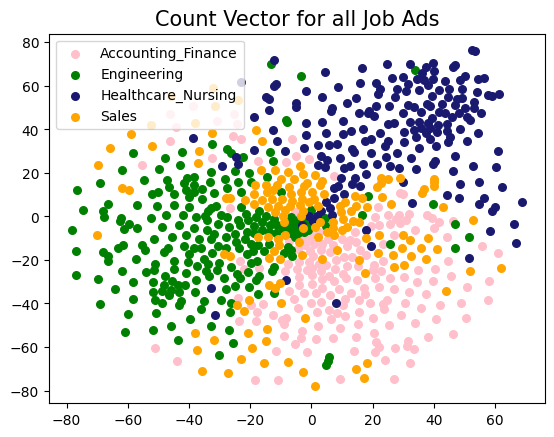

In [11]:
plotTSNE(df_job_ad["category"],np.array(count_list), "Count Vector")

As shown in above scatter, there are 3 kinds of jobs are separated. They are Accounting & Finance, Engineering and Healthcare & Nursing. But job ads belong to Sales mixed with each other and in the center of the scatter. It may be because job skills related to sales are quite common. And, there is no specific skills required for Sales which is not like other professional jobs.

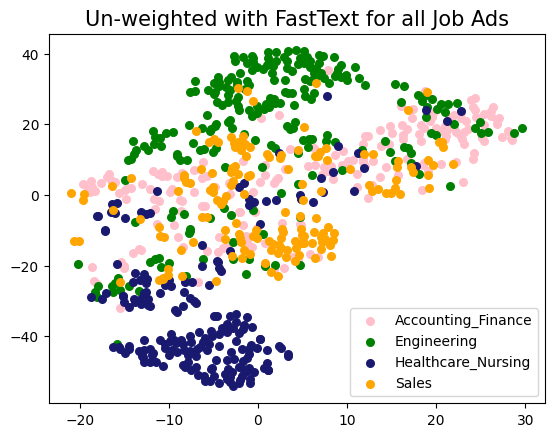

In [12]:
plotTSNE(df_job_ad["category"],np.array(unweighted_list), "Un-weighted with FastText")

As shown in above scatter, there are 2 kinds of jobs are separated. They are Engineering and Healthcare & Nursing. But job ads belong to Sales and Accounting & Finance mixed together and in the center of the scatter. FastText shows that the job features of Accounting & Finance and Sales are quite similar. Also, there are many green dots are with orange and pink. It means that Engineering jobs also needs some common skills  besides some professional skills.

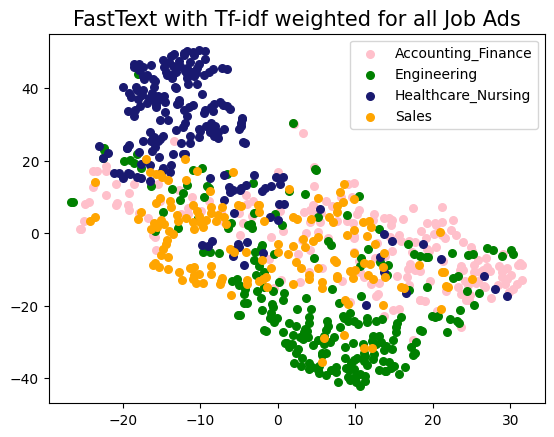

In [13]:
plotTSNE(df_job_ad["category"],np.array(weighted_list), "FastText with Tf-idf weighted")

Tf-idf weighted vector is similar to the un-weighted. Engineering and Healthcare & Nursing are separated while Sales and Accounting & Finance are mixed. However, the green and blue dots are more concentrated comparing to the un-weighted vector. It means that there are many common words which may not be related to job features, and they appear in lots of other job advertisements.

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [14]:
# save files with count_vectors.txt, w+ for saving file with not exist file
# format word_integer_index:word_freq , word_freq => idx1:count1,idx10:count2,idxN:countN
save_count_vector(job_ad_list, vocab_dict)

## Task 3. Job Advertisement Classification

```generate_list_for_modelling``` will return 3 different metrics for Logistic Regression model.
By passing the second last parameter as ```"desc"```, it means that the ML model is determined by tokens of description only.
By passing the last parameter as ```True```, it will return ```csr_matrix``` for model learning.

In [15]:
desc_words = list(chain.from_iterable([job_ad.desc_tokens for job_ad in job_ad_list]))
count_desc_matrix, unweighted_desc_matrix, weighted_desc_matrix = generate_list_for_modelling(job_ad_list, list(vocab_dict.keys()),
                                                                         vector_size, tfidf_features, model_ft, "desc", True)

errors noted: 0


There is no error because all tokens passed are in Tf-idf matrix.

#### Language model comparisons (Q1)
```generate_cv_df``` is a function for passing the word embedding model (metrics) into Logistic Regression model also with evaluation by 5-fold cross validation.

##### Description only

In [17]:
cv_desc_df = generate_cv_df(count_desc_matrix, unweighted_desc_matrix, weighted_desc_matrix, df_job_ad["category"], seed)
cv_desc_df

,count,unweighted,tfidf-weighted,tfidf,weighted-tfidf
0,0.858974,NaN,NaN,0.775641,0.750000
1,0.890323,NaN,NaN,0.806452,0.754839
2,0.877419,NaN,NaN,0.741935,0.703226
3,0.864516,NaN,NaN,0.767742,0.774194
4,0.883871,NaN,NaN,0.845161,0.819355


In [18]:
cv_desc_df.mean()

count             0.875021
unweighted             NaN
tfidf-weighted         NaN
tfidf             0.787386
weighted-tfidf    0.760323
dtype: float64

Count vector performance is the best while FastText with Tf-idf weighted performance is the worst. Both model with FastText are near and lower than 70% which are considered as a bad result. It may be because the size of set of documents is too small. The total size of all job advertisements is 776 and there are less than 200 files for each category of job advertisement. The total size of vocabs is about 5000 which is a quite small number. Also, FastText is a self-trained language embedding model. There is no external word libraries loaded to the model. Therefore, the word library in this exercise is narrow. That is also the reason of weighted-tfidf result is worse than unweighted.

Also, a description of a job advertisement are usually abnormal sentences. Therefore, a normal window size of 2 should not be applied. It should be less than normal.

#### More information provide higher accuracy? (Q2)

##### Title only

In [19]:
tVectorizer_title = TfidfVectorizer(analyzer = "word",vocabulary = title_token_list) # initialised the TfidfVectorizer
tfidf_title_features = tVectorizer_title.fit_transform([' '.join(job_ad.title_tokens) for job_ad in job_ad_list]) # generate the tfidf vector representation for all articles

In [20]:
count_title_matrix, unweighted_title_matrix, weighted_title_matrix = generate_list_for_modelling(job_ad_list, sorted(title_token_list), vector_size, tfidf_title_features, model_ft, "title", True)

errors noted: 0


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle
unweighted_title_matrix
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(unweighted_title_matrix, df_job_ad["category"],
                                                                                     list(range(0, len(df_job_ad["category"]))),
                                                                                     test_size=0.01, random_state=seed)
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)
pickle.dump(model, open('lr_model.pkl', 'wb'))

In [21]:
cv_title_df = generate_cv_df(count_title_matrix, unweighted_title_matrix, weighted_title_matrix, df_job_ad["category"], seed)
cv_title_df

,count,unweighted,tfidf-weighted,tfidf,weighted-tfidf
0,0.801282,NaN,NaN,0.717949,0.705128
1,0.832258,NaN,NaN,0.800000,0.754839
2,0.845161,NaN,NaN,0.722581,0.735484
3,0.83871,NaN,NaN,0.729032,0.683871
4,0.825806,NaN,NaN,0.774194,0.761290


In [22]:
cv_title_df.mean()

count             0.828644
unweighted             NaN
tfidf-weighted         NaN
tfidf             0.748751
weighted-tfidf    0.728122
dtype: float64

In [23]:
len(title_token_list)

1003

The result of title only is worse than description. There are about 1000 vocabs for title. It is obviously not enough words for embedding language model to train. The vocab size between title and description is 4000. But, it only increases 2% of accuracy. 4 times of vocabs only for increasing 2% accuracy. Is it worthy? The answer is no for this analysis.

##### Description and Title

In [24]:
tVectorizer_all = TfidfVectorizer(analyzer = "word",vocabulary = all_token_list) # initialised the TfidfVectorizer
tfidf_all_features = tVectorizer_all.fit_transform([' '.join(job_ad.all_tokens) for job_ad in job_ad_list]) # generate the tfidf vector representation for all articles

In [25]:
count_all_matrix, unweighted_all_matrix, weighted_all_matrix = generate_list_for_modelling(job_ad_list, sorted(all_token_list), vector_size, tfidf_all_features, model_ft, "all", True)

errors noted: 0


In [ ]:
cv_all_df = generate_cv_df(count_all_matrix, unweighted_all_matrix, weighted_all_matrix, df_job_ad["category"], seed)
cv_all_df

In [ ]:
cv_all_df.mean()

In [ ]:
len(all_token_list)

There are more about 200 vocabs for tokens with both title and description. However, it does not improve the evaluation result. So, more information does not provide higher accuracy in this case. It would be better if the document size is larger for boosting up the accuracy.

## Summary
This assignment marks vs. times effort is more balance than assignment 1.Students can learn from this assignment how to apply natural language processing skill with machine learning model in real practical case. For task 2, it is not clear that how to build a embedding language model with weighted an un-weighted vector. Also, it is only required to output bag-of-words model but not with word embeddings model. It makes me confuse that I finished Task 2. Also, there is no hint for students to evaluate the result in Task 2. So, I used t-SNE to evaluate the result in Task 2. For task 3, it is a good practice for students to compare and analyze.

# BACK UP

In [ ]:
# def get_job_ad_by_web_index(idx):
#     for job_ad in job_ad_list:
#         if job_ad.get_web_index() == idx:
#             return job_ad
#     return None

In [ ]:
# job_2209 = get_job_ad_by_web_index('71692209')
# print(job_2209)

In [ ]:
# job_ad_dvs = gen_docVecs(job_ad_FT_wv, df_job_ad['desc_tokens'])
# job_ad_dvs.isna().any().sum()

In [ ]:
# # extended version of the `gen_docVecs` function
# def gen_docVecs(wv,tk_txts,tfidf = []): # generate vector representation for documents
#     docs_vectors = pd.DataFrame() # creating empty final dataframe
#
#     for i in range(0,len(tk_txts)):
#         tokens = list(set(tk_txts[i])) # get the list of distinct words of the document
#
#         temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
#         for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
#             try:
#                 word = tokens[w_ind]
#                 word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
#
#                 if tfidf != []:
#                     word_weight = float(tfidf[i][word])
#                 else:
#                     word_weight = 1
#                 temp = temp.append(pd.Series(word_vec*word_weight), ignore_index = True) # if word is present then append it to temporary dataframe
#             except:
#                 pass
#         doc_vector = temp.sum() # take the sum of each column(w0, w1, w2,........w300)
#         docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
#     return docs_vectors

In [ ]:
# for vec_size in [10]:
# # for vec_size in [10, 50, 100, 200, 500, 750]:
# # vec_size = 10
#     vec_job_ad_FT = FastText.load("job_ad_FT_{}.model".format(vec_size))
#     vec_job_ad_FT_wv = vec_job_ad_FT.wv
#     for tfidf in [[], job_ad_tfidf_weights]:
#         vec_job_ad_dvs = gen_docVecs(vec_job_ad_FT_wv,df_job_ad['desc_tokens'],tfidf)
#         weight_str = ""
#         if tfidf:
#            weight_str = "Weighted"
#         else:
#             weight_str = "Not Weighted"
#         features = vec_job_ad_dvs.to_numpy()
#         plotTSNE(df_job_ad['category'],features)
#
#         seed=0
#         X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(vec_job_ad_dvs, df_job_ad['category'], list(range(0,len(df_job_ad))),test_size=0.33, random_state=seed)
#
#         model = LogisticRegression(max_iter = 1000,random_state=seed)
#         model.fit(X_train, y_train)
#         print("{} Accuracy - {}: {}".format(weight_str, vec_size, model.score(X_test, y_test)))
#
#         # cross-validation
#         scores = cross_val_score(model, X_train, y_test, cv=5)
#         print("Cross validation scores:", scores)
#         print("Mean score:", np.mean(scores))

In [ ]:
# job_ad_tfidf_weights = []
#
# for job_ad_tfidf_feature in tfidf_features.toarray():
#     wordweight_dict = {}
#     for word, value in zip(vocab_dict.keys(), job_ad_tfidf_feature):
#         if value > 0:
#             wordweight_dict[word] = value
#     job_ad_tfidf_weights.append(wordweight_dict)
#                 # print(word+":"+str(value), end =' ')
# # print(job_ad_tfidf_weights)